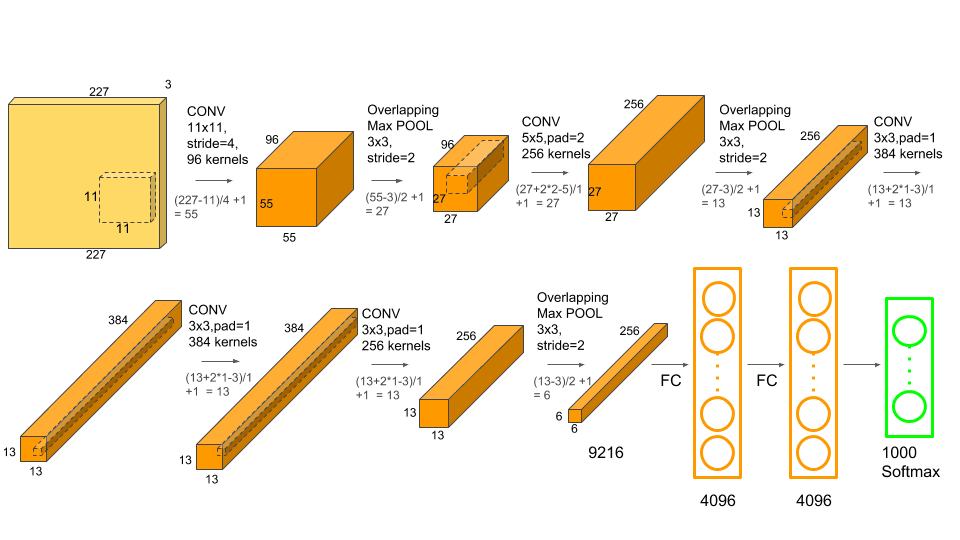

In [2]:
#Alexnet Architecture
import os 
os.getcwd() #check current directory
os.chdir('/Users/jaehyoyi/Desktop/') # move to Desktop directory
from IPython.display import Image, display
#cd /Users/jaehyoyi/Desktop
display(Image(filename='Alexnet.png'))
#picture from : https://medium.com/analytics-vidhya/concept-of-alexnet-convolutional-neural-network-6e73b4f9ee30


In [3]:
#Alexnet code
#Reference : https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40
            #https://ingu627.github.io/code/alexnet_pytorch/


#Import Necessary packages(?)

import os   #In python, use to copy files, make directory, change directory etc
import torch
import torch.nn as nn #nn stands for neural networks --> use attribute to make states
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision        #torch vision packages include datasets, model architecture, image transformation etc
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader


In [4]:
#Define Epoch, batch size, device

epochs = 10
batch_size = 512

device = ("cuda" if torch.cuda.is_available() else "cpu") #Use GPU if avaliable, if not use cpu
class_names = [
    "T-shirt/top", "Trouse", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
] 
#FASHION_MNIST Dataset has 10 classes


print(torch.__version__)
print(device) #check if using cpu or gpu

2.0.1
cpu


In [5]:
#Import more packages(?)
#Prepare Dataset

transform = transforms.Compose([
    transforms.Resize(227),     #FashionMNIST data is 28x28 so has to change to 227x227   
    transforms.ToTensor()   #TO Tensor : PIL image or numpy, ndarray --> tensor로 바꿈
    
])


training_data = datasets.FashionMNIST(
   root="data", #path where to save the data
    train=True, #it is a training dataset
    download = True ,#download from internet
    transform = transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, #test data
    download=True,
    transform=transform
)




In [6]:
#Define dataloader
#데이터로더는 데이터를 배치 단위로 모델에 밀어주는 역할, 전체 데이터 가운데 일부를 뽑아 sample를 구성한다

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Sandal


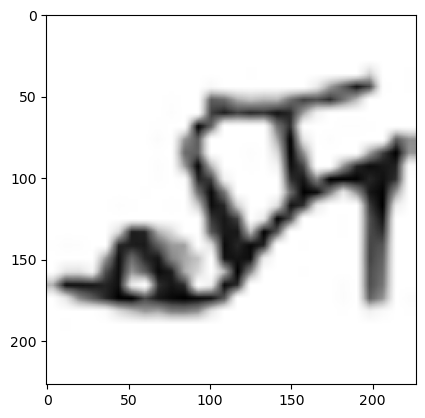

In [7]:
#Look at some images

def matplotlib_imshow(img):
    #function to show an image
    img = img.mean(dim=0)
    img = img/ 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap = "Greys")


#get some random training images
dataiter = iter(training_loader) #iter --> repeat stuff
images, labels = next(dataiter) #next() : 반복할 수 있을때는 해당 값을 출력, 반복이 끝났을때는 기본값을 출력


#create grid of images
img_grid = torchvision.utils.make_grid(images[0])    #make_grid : 이미지의 그리드(?) 생성하기


#show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])






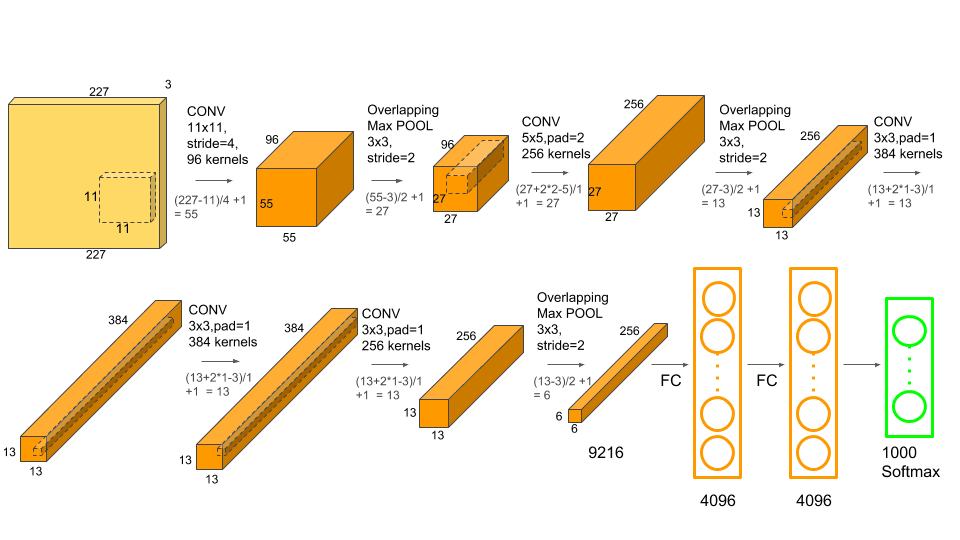

In [8]:
from IPython.display import Image, display
#cd /Users/jaehyoyi/Desktop
display(Image(filename='Alexnet.png'))

In [9]:
#define Alexnet

class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=96, kernel_size= 11, stride = 4, padding = 0),
            #first convolution
            #4D tensor : [number_of_kernels, input_channels, kernel_width, kernel_height]
            #input size : 1 x 277 x 277 (black/white image : channel 1)

            #277 --> (277-11+1)/4 = 55
            #96 x 55 x 55 feature map

            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) #maxpooling layer
            # 55 --> (55-3+1)/2 = 26.5 = 27
            #96 x 27 x 27 feature map 

        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1 ,2), #input_channel : 96, output_channel:256, kernel_size :5x5, stride = 1, padding=2
            #channel : 48, since used dropout 96/2 = 48
            #W' = (W-F+2P)/S+1 
            nn.ReLU(),
            nn.MaxPool2d(3,2) #kernel size 3, stride = 2
            #256x13x13

            

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
            #384x13x13
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1), #output_channel : 384, kernel_size:3, stride=1, padding=1
            nn.ReLU()
            #384x13x13
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1), #output_channel:256
            nn.ReLU(),
            nn.MaxPool2d(3,2) #change channel size to 13 to 6
            #256x6x6
        )


        #3 fully-connected layer at the end
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    #forward pass function
    def forward(self, x):    #input size = 3x277x277
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.conv5(out)   #64x4096x1x1
        out=out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))
        out= F.dropout(out, 0.5) #dropout half
        out = F.relu(self.fc2(out))
        out= F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1) #softmax at last layer for classification

        return out
        



In [10]:
#Define the model
model = fashion_mnist_alexnet().to(device)
criterion = F.nll_loss #negative log liklihood loss
optimizer = optim.Adam(model.parameters()) 

In [11]:
#see the summary of the model

from torchsummary import summary as summary_
summary_(model, (1,227,227), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

In [12]:
#define train

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() #before backpropagation, make sure to make gradient to be zero
        output = model(data)
        loss = criterion(output, target) #criterion = loss_fn
        loss.backward() #this computs the gradient of curve tensor with regartd to graph levels
        optimizer.step() #step() : this updates the parameters
        if (batch_idx+1 )%30 ==0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            


In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [14]:
#start the model

for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

 #epoch 7 --> gives accuracy of 91%   

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.056784
Train Epoch:1 [3776/60000 (6%)]	Loss: 1.076851
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.655104
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.752669
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.733071
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.510078
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.458623
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.562055
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.533958
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.364680
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.488207
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.458824
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.263032
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.248260
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.409092
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.347119
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.404602
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.523933
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.281287
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.435158
Train Epoch:1 [40256/60000 (

KeyboardInterrupt: 